# 데이터 EDA
- 데이터의 수
    - 연간, 월간 데이터 수 확인
    - 법정동 거래 수 확인

In [6]:
import model.download.api as api
from sqlalchemy import inspect, text
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

In [7]:
# db 연결
eng= api.create_engine('sqlite:////Users/hj/Dropbox/real_estate/data/commercial/house.db') # commercial_raw


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

query = 'SELECT * FROM commercial_raw ORDER BY ROWID DESC LIMIT 10'
with eng.connect() as conn:
    df = pd.read_sql(query, conn)

df.drop(columns = ['거래유형', '대지면적', '매도자', '매수자'])

,거래금액,건물면적,건물주용도,건축년도,년,법정동,시군구,용도지역,월,유형,일,중개사소재지,지번,지역코드,층,해제사유발생일,해제여부,구분
0,"6,300",61.15,숙박,2006,2024,봉평면 진조리,평창군,계획관리,5,집합,1,None,70,51760,1,None,None,None
1,"2,000",16.76,판매,1992,2024,소양로2가,춘천시,일반상업,5,집합,1,None,172-1,51110,None,None,None,None
2,"46,730",70.81,제2종근린생활,2019,2024,외북동,청주흥덕구,준공업,5,집합,1,None,317,43113,1,None,None,None
3,"56,720",78.8,제2종근린생활,2019,2024,외북동,청주흥덕구,준공업,5,집합,1,None,317,43113,1,None,None,None
4,"30,730",46.56,제2종근린생활,2019,2024,외북동,청주흥덕구,준공업,5,집합,1,None,317,43113,1,None,None,None
5,"31,800",46.08,제2종근린생활,2019,2024,외북동,청주흥덕구,준공업,5,집합,1,None,317,43113,1,None,None,None
6,"36,140",52.38,제2종근린생활,2019,2024,외북동,청주흥덕구,준공업,5,집합,1,None,317,43113,1,None,None,None
7,"60,130",95.4,제2종근린생활,2019,2024,외북동,청주흥덕구,준공업,5,집합,1,None,317,43113,1,None,None,None
8,"56,850",78.96,제2종근린생활,2019,2024,외북동,청주흥덕구,준공업,5,집합,1,None,317,43113,1,None,None,None
9,"50,800",70.56,제2종근린생활,2019,2024,외북동,청주흥덕구,준공업,5,집합,1,None,317,43113,1,None,None,None


## 중복 데이터 제거

In [9]:
delete_query = text('''
                    CREATE TABLE commercial AS
                    SELECT *
                    FROM commercial_raw
                    WHERE ROWID IN (
                        SELECT MIN(ROWID)
                        FROM commercial_raw
                        GROUP BY 거래금액, 건물면적, 년, 월, 일, 지역코드
                    )
                    
''')

with eng.connect() as conn:
    conn.execute(delete_query)

OperationalError: (sqlite3.OperationalError) table commercial already exists
[SQL: 
                    CREATE TABLE commercial AS
                    SELECT *
                    FROM commercial_raw
                    WHERE ROWID IN (
                        SELECT MIN(ROWID)
                        FROM commercial_raw
                        GROUP BY 거래금액, 건물면적, 년, 월, 일, 지역코드
                    )
                    
]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [87]:


with eng.connect() as conn:
   result = conn.execute(text('SELECT COUNT(*) FROM commercial_raw'))
   print(f"중복 제거 전 데이터 수 : {result.scalar()}")

   result = conn.execute(text('SELECT COUNT(*) FROM commercial'))
   print(f"중복 제거 후 데이터 수 : {result.scalar()}")

중복 제거 전 데이터 수 : 1420459
중복 제거 후 데이터 수 : 1234916


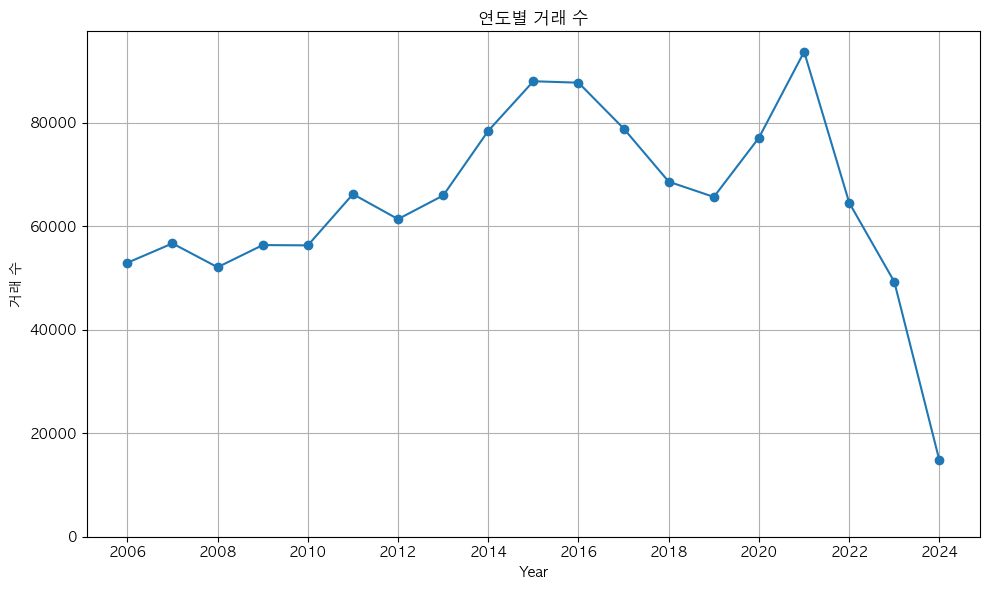

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

query = api.text('SELECT 년, COUNT(*) as count FROM commercial GROUP BY 년')
with eng.connect() as conn:
    result = conn.execute(query)
    data = result.fetchall()

df = pd.DataFrame(data, columns=['year', 'count'])
df['year'] = pd.to_datetime(df['year'], format = '%Y')
df.set_index('year', inplace= True)

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['count'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('거래 수')
plt.title('연도별 거래 수')
plt.ylim(bottom = 0)
plt.grid(True)
plt.tight_layout()
plt.show()

## 연도별 평균 거래 액

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from sqlalchemy import create_engine, text


# 데이터베이스 엔진 생성
engine = create_engine('sqlite:////Users/hj/Dropbox/real_estate/data/commercial/house.db')

# 데이터베이스 연결 및 쿼리 실행
with engine.connect() as connection:
    query = text('SELECT 년 as year, 거래금액 as price FROM commercial')
    result = connection.execute(query)
    data = result.fetchall()

# 결과를 DataFrame으로 변환
df = pd.DataFrame(data, columns=['year', 'price'])

# 'price' 칼럼을 숫자 형식으로 변환 (쉼표 제거 후 변환)
df['price'] = df['price'].replace(',', '', regex=True).astype(float)

# 'year' 칼럼을 datetime 형식으로 변환 (연도만 포함)
df['year'] = pd.to_datetime(df['year'], format='%Y')

# 연도별 평균 거래금액 계산
average_price_per_year = df.groupby(df['year'].dt.year)['price'].mean()

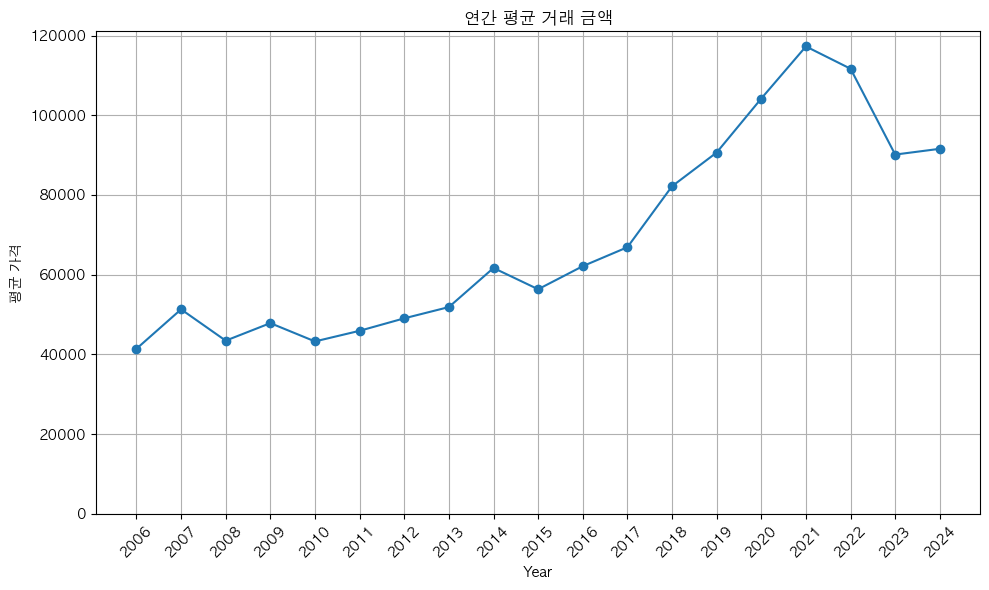

In [90]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(average_price_per_year.index, average_price_per_year.values, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('평균 가격')
plt.title('연간 평균 거래 금액')

plt.ylim(bottom=0)

# x축 레이블 회전
plt.xticks(ticks=average_price_per_year.index, rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


# 중복 데이터 제거

In [75]:
inspector.get_columns('commercial_raw')

with eng.connect()

[{'name': '거래금액',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': '거래유형',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': '건물면적',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': '건물주용도',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': '건축년도',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': '년',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': '대지면적',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': '매도자',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': '매수자',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': '법정동',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': '시군구',
  'type': TEXT(),
  'nullabl